<a href="https://colab.research.google.com/github/fire-long/24-1DeepLearning/blob/main/Assignment2_CNN%26TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#실습 과제 1
Lab 3 CNN MNIST 실습에서 Dropout 을 추가하기 전과 후의 모델을 각각
학습시키고 결과를 논의하세요.

## CNNs with/without Dropout

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:06<00:00, 1508793.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 156945.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 1509663.96it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15862222.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Batch 200, Dropout Train Loss: 0.513, Accuracy: 83.67%
Epoch 1, Batch 400, Dropout Train Loss: 0.191, Accuracy: 94.30%
Epoch 1, Batch 600, Dropout Train Loss: 0.157, Accuracy: 95.61%
Epoch 1, Batch 800, Dropout Train Loss: 0.129, Accuracy: 96.16%
Epoch 1, Batch 200, No Dropout Train Loss: 0.339, Accuracy: 89.90%
Epoch 1, Batch 400, No Dropout Train Loss: 0.097, Accuracy: 97.23%
Epoch 1, Batch 600, No Dropout Train Loss: 0.071, Accuracy: 97.75%
Epoch 1, Batch 800, No Dropout Train Loss: 0.063, Accuracy: 98.00%
Epoch 1, Dropout Train Accuracy: 96.53%, Test Accuracy: 96.66%, No Dropout Train Accuracy: 98.31%, Test Accuracy: 98.43%
Epoch 2, Batch 200, Dropout Train Loss: 0.106, Accuracy: 96.95%
Epoch 2, Batch 400, Dropout Train Loss: 0.107, Accuracy: 96.67%
Epoch 2, Batch 600, Dropout Train Loss: 0.089, Accuracy: 97.38%
Epoch 2, Batch 800, Dropout Train Loss: 0.095, Accuracy: 97.26%
Epoch 2, Batch 200, No Dropout Train Loss: 0.044, Accuracy: 98.72%
Epoch 2, Batch 400, No Dropout T

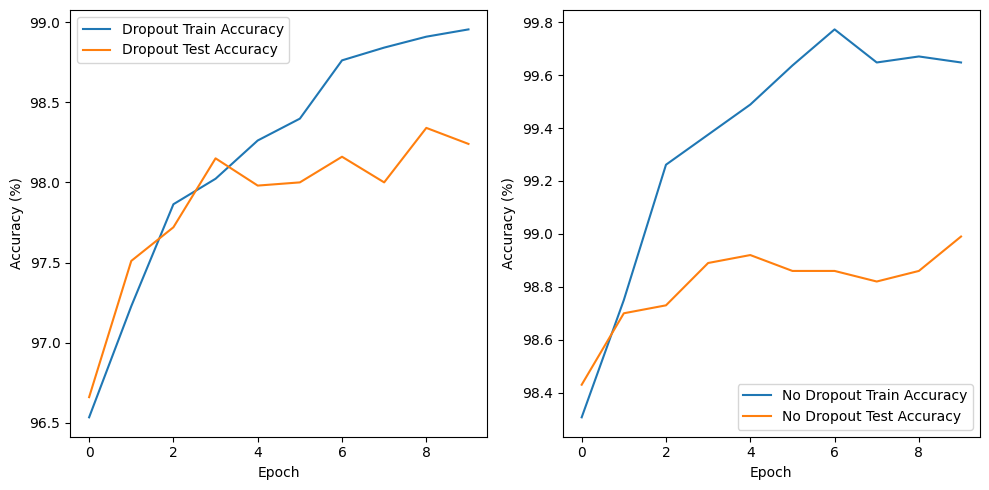

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define the transformations and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architectures
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

class NetDropout(nn.Module):
    def __init__(self):
        super(NetDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_dropout = NetDropout().to(device)
net_nodropout = Net().to(device)

# Step 3: Define a Loss function and Optimizers
criterion = nn.CrossEntropyLoss()
optimizer_dropout = optim.Adam(net_dropout.parameters(), lr=0.001)
optimizer_nodropout = optim.Adam(net_nodropout.parameters(), lr=0.001)

# 새로운 리스트를 만들어 각 epoch의 train/test accuracy를 저장.
train_accs_dropout = []
train_accs_nodropout = []
test_accs_dropout = []
test_accs_nodropout = []

# Step 4: Train the Networks
for epoch in range(10):
    # Dropout 모델 학습
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer_dropout.zero_grad()

        outputs = net_dropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_dropout.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print every 200 mini-batches
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Dropout Train Loss: {running_loss / 200:.3f}, Accuracy: {accuracy:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0

    # Dropout 모델 train accuracy 계산 및 저장
    train_acc_dropout = 100. * correct / total
    train_accs_dropout.append(train_acc_dropout)

    # Dropout 모델 test accuracy 계산 및 저장
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_dropout(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc_dropout = 100. * correct / total
    test_accs_dropout.append(test_acc_dropout)

    # 비적용 모델 학습
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer_nodropout.zero_grad()

        outputs = net_nodropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_nodropout.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print every 200 mini-batches
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, No Dropout Train Loss: {running_loss / 200:.3f}, Accuracy: {accuracy:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0

    # 비적용 모델 train accuracy 계산 및 저장
    train_acc_nodropout = 100. * correct / total
    train_accs_nodropout.append(train_acc_nodropout)

    # 비적용 모델 test accuracy 계산 및 저장
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_nodropout(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc_nodropout = 100. * correct / total
    test_accs_nodropout.append(test_acc_nodropout)

    print(f'Epoch {epoch + 1}, Dropout Train Accuracy: {train_acc_dropout:.2f}%, Test Accuracy: {test_acc_dropout:.2f}%, No Dropout Train Accuracy: {train_acc_nodropout:.2f}%, Test Accuracy: {test_acc_nodropout:.2f}%')

print('Finished Training')

# Step5:결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs_dropout, label='Dropout Train Accuracy')
plt.plot(test_accs_dropout, label='Dropout Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_nodropout, label='No Dropout Train Accuracy')
plt.plot(test_accs_nodropout, label='No Dropout Test Accuracy')
plt.xlabel('Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Weight shape: (32, 1, 3, 3)


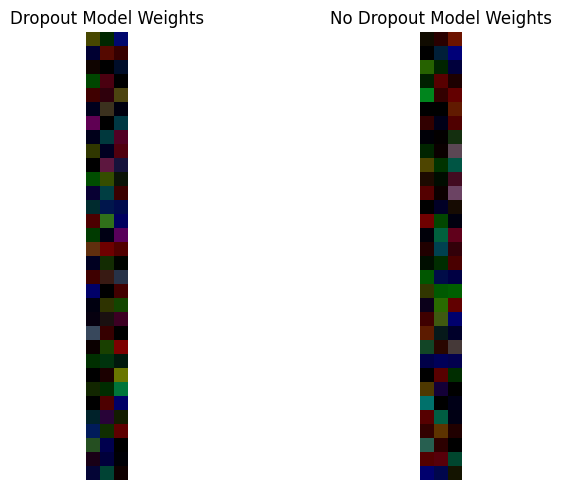

In [2]:
def plot_weights(model1, model2, layer_idx):
    weights1 = model1.state_dict()[list(model1.state_dict().keys())[layer_idx]].cpu().data.numpy()
    weights2 = model2.state_dict()[list(model2.state_dict().keys())[layer_idx]].cpu().data.numpy()
    print(f"Weight shape: {weights1.shape}")

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(weights1.reshape(weights1.shape[0], weights1.shape[2], weights1.shape[3]), cmap='viridis')
    axs[0].set_title('Dropout Model Weights')
    axs[0].axis('off')

    axs[1].imshow(weights2.reshape(weights2.shape[0], weights2.shape[2], weights2.shape[3]), cmap='viridis')
    axs[1].set_title('No Dropout Model Weights')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# 두 모델의 첫 번째 컨볼루션 층 가중치 시각화
plot_weights(net_dropout, net_nodropout, 0)

#실습 과제 2
Lab 3 CNN MNIST 실습에서 데이터셋을 CIFAR10으로 바꾸고 Global
Average Pooling를 추가하기 전과 후 모델을 각각 수정하여 약 1M 개의 파라미터로 학습시키고 비교하여 결과를 논의하세요.


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss: 1.310, Train Acc: 52.57%, Test Loss: 0.933, Test Acc: 67.32%
Epoch 2: Train Loss: 0.805, Train Acc: 71.80%, Test Loss: 0.784, Test Acc: 72.40%
Epoch 3: Train Loss: 0.610, Train Acc: 78.64%, Test Loss: 0.702, Test Acc: 76.08%
Epoch 4: Train Loss: 0.467, Train Acc: 83.74%, Test Loss: 0.698, Test Acc: 77.02%
Epoch 5: Train Loss: 0.335, Train Acc: 88.23%, Test Loss: 0.766, Test Acc: 77.48%
Epoch 6: Train Loss: 0.239, Train Acc: 91.68%, Test Loss: 0.881, Test Acc: 76.87%
Epoch 7: Train Loss: 0.167, Train Acc: 94.13%, Test Loss: 1.103, Test Acc: 75.34%
Epoch 8: Train Loss: 0.139, Train Acc: 95.11%, Test Loss: 1.153, Test Acc: 75.61%
Epoch 9: Train Loss: 0.113, Train Acc: 96.05%, Test Loss: 1.270, Test Acc: 75.21%
Epoch 10: Train Loss: 0.093, Train Acc: 96.87%, Test Loss: 1.345, Test Acc: 76.28%
Epoch 1: Train Loss: 1.665, Train Acc: 36.26%, Test Loss: 1.390, Test Acc: 47.60%
Epoch 2: Train Loss: 

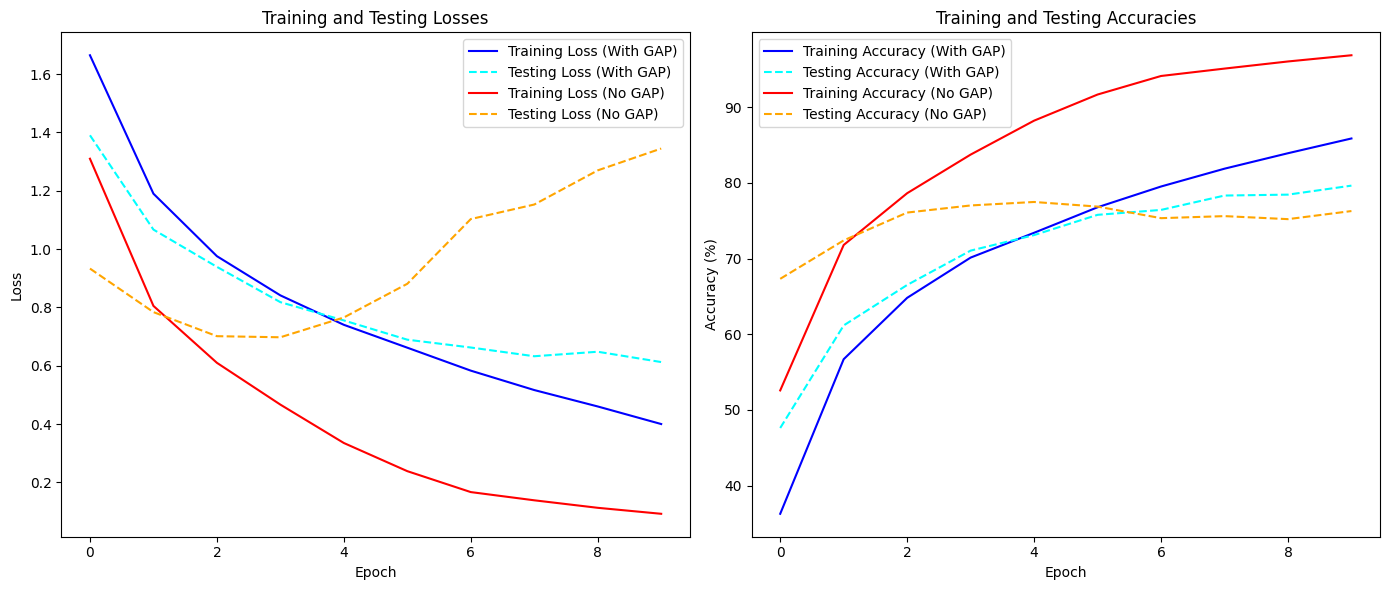

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 데이터셋 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# 네트워크 아키텍처 정의
class NetWithoutGAP(nn.Module):
    def __init__(self):
        super(NetWithoutGAP, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class NetWithGAP(nn.Module):
    def __init__(self):
        super(NetWithGAP, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 모델 초기화 및 최적화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_without_gap = NetWithoutGAP().to(device)
model_with_gap = NetWithGAP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_without_gap = optim.Adam(model_without_gap.parameters(), lr=0.001)
optimizer_with_gap = optim.Adam(model_with_gap.parameters(), lr=0.001)

# Train and evaluate functions
def train_and_evaluate_model(model, optimizer, trainloader, testloader, epochs=10):
    model.train()
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss = test_loss / len(testloader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.3f}, Test Acc: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_losses, test_accuracies

# Train and evaluate both models
train_losses_without_gap, train_accuracies_without_gap, test_losses_without_gap, test_accuracies_without_gap = train_and_evaluate_model(
    model_without_gap, optimizer_without_gap, trainloader, testloader)

train_losses_with_gap, train_accuracies_with_gap, test_losses_with_gap, test_accuracies_with_gap = train_and_evaluate_model(
    model_with_gap, optimizer_with_gap, trainloader, testloader)

# 결과 시각화
plt.figure(figsize=(14, 6))

# Plot Losses on the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(train_losses_with_gap, label='Training Loss (With GAP)', color='blue')
plt.plot(test_losses_with_gap, label='Testing Loss (With GAP)', color='cyan', linestyle='--')
plt.plot(train_losses_without_gap, label='Training Loss (No GAP)', color='red')
plt.plot(test_losses_without_gap, label='Testing Loss (No GAP)', color='orange', linestyle='--')
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies on the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(train_accuracies_with_gap, label='Training Accuracy (With GAP)', color='blue')
plt.plot(test_accuracies_with_gap, label='Testing Accuracy (With GAP)', color='cyan', linestyle='--')
plt.plot(train_accuracies_without_gap, label='Training Accuracy (No GAP)', color='red')
plt.plot(test_accuracies_without_gap, label='Testing Accuracy (No GAP)', color='orange', linestyle='--')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()

#실습 과제 3
위 실습 과제 2, GAP를 추가한 모델에서 BatchNorm을 추가하기 전과 후를 각각 학습시키고 결과를 논의하세요.

Files already downloaded and verified
Files already downloaded and verified
Model NetWithBN - Epoch 1: Train Loss: 1.206, Train Acc: 56.03%, Test Loss: 0.999, Test Acc: 64.50%
Model NetWithBN - Epoch 2: Train Loss: 0.819, Train Acc: 70.98%, Test Loss: 0.780, Test Acc: 72.08%
Model NetWithBN - Epoch 3: Train Loss: 0.650, Train Acc: 77.27%, Test Loss: 0.771, Test Acc: 73.75%
Model NetWithBN - Epoch 4: Train Loss: 0.548, Train Acc: 80.87%, Test Loss: 0.747, Test Acc: 74.43%
Model NetWithBN - Epoch 5: Train Loss: 0.457, Train Acc: 83.96%, Test Loss: 0.769, Test Acc: 74.12%
Model NetWithBN - Epoch 6: Train Loss: 0.376, Train Acc: 86.89%, Test Loss: 0.610, Test Acc: 79.84%
Model NetWithBN - Epoch 7: Train Loss: 0.310, Train Acc: 89.20%, Test Loss: 0.630, Test Acc: 79.57%
Model NetWithBN - Epoch 8: Train Loss: 0.251, Train Acc: 91.30%, Test Loss: 0.662, Test Acc: 80.07%
Model NetWithBN - Epoch 9: Train Loss: 0.209, Train Acc: 92.65%, Test Loss: 0.858, Test Acc: 77.01%
Model NetWithBN - Epoch 

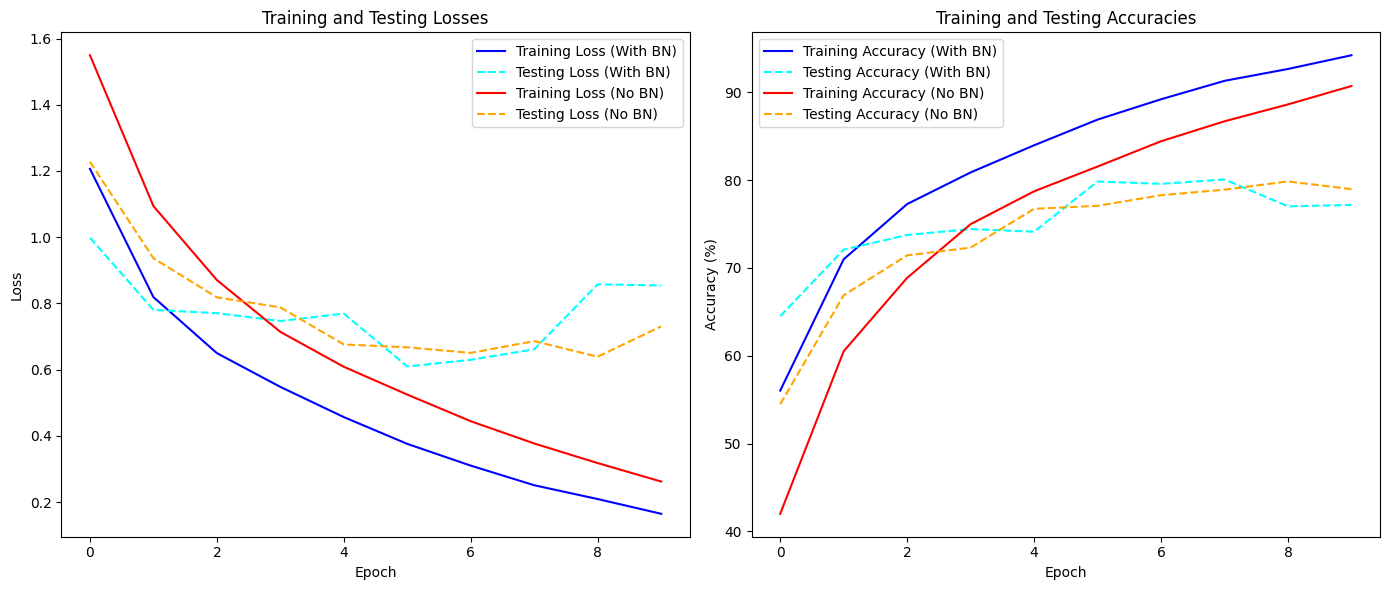

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize for 3 channels #평균 3 분산 3

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

class NetWithBN(nn.Module):
    def __init__(self):
        super(NetWithBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_avg_pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class NetWithoutBN(NetWithBN):
    def __init__(self):
        super(NetWithoutBN, self).__init__()
        # Remove BatchNorm layers
        del self.bn1, self.bn2, self.bn3, self.bn4

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.global_avg_pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_bn = NetWithBN().to(device)
model_without_bn = NetWithoutBN().to(device)

# Step 3: Define a Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_with_bn = optim.Adam(model_with_bn.parameters(), lr=0.001)
optimizer_without_bn = optim.Adam(model_without_bn.parameters(), lr=0.001)

# Step 4/5/6: Setup and train &test networks
def train_and_evaluate(model, optimizer, epochs=10):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(testloader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Model {model.__class__.__name__} - Epoch {epoch + 1}: Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.3f}, Test Acc: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_losses, test_accuracies


# Train and evaluate both models

train_losses_with_bn, train_accuracies_with_bn, test_losses_with_bn, test_accuracies_with_bn = train_and_evaluate(model_with_bn, optimizer_with_bn)
train_losses_without_bn, train_accuracies_without_bn, test_losses_without_bn, test_accuracies_without_bn = train_and_evaluate(model_without_bn, optimizer_without_bn)
print('Finished Training&Evaluation')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(14, 6))

# Plot Losses on the first subplot
plt.subplot(1, 2, 1)
plt.plot(train_losses_with_bn, label='Training Loss (With BN)', color='blue')
plt.plot(test_losses_with_bn, label='Testing Loss (With BN)', color='cyan', linestyle='--')
plt.plot(train_losses_without_bn, label='Training Loss (No BN)', color='red')
plt.plot(test_losses_without_bn, label='Testing Loss (No BN)', color='orange', linestyle='--')
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies on the second subplot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_with_bn, label='Training Accuracy (With BN)', color='blue')
plt.plot(test_accuracies_with_bn, label='Testing Accuracy (With BN)', color='cyan', linestyle='--')
plt.plot(train_accuracies_without_bn, label='Training Accuracy (No BN)', color='red')
plt.plot(test_accuracies_without_bn, label='Testing Accuracy (No BN)', color='orange', linestyle='--')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

#실습 과제 4
Lab 3 Transfer Learning 실습에서 ResNet18의 (i) learnable parameters을 고정한 경우와 (ii) 마지막 3개 Layer만 제외하고 나머지 learnable parameters를 고정한 경우, (iii) 모든 레이어를 고정하지 않은 경우에 대해 학습시키고 결과를 논의하세요.

Files already downloaded and verified
Files already downloaded and verified

Training case 1: All frozen


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 - Training Loss: 0.8512, Acc: 72.60%, Validation Loss: 0.6208, Acc: 79.36%
Epoch 2 - Training Loss: 0.6226, Acc: 78.73%, Validation Loss: 0.5811, Acc: 79.92%
Epoch 3 - Training Loss: 0.5952, Acc: 79.42%, Validation Loss: 0.5703, Acc: 79.88%
Epoch 4 - Training Loss: 0.5801, Acc: 80.00%, Validation Loss: 0.5615, Acc: 80.42%
Epoch 5 - Training Loss: 0.5640, Acc: 80.43%, Validation Loss: 0.5492, Acc: 80.70%
Epoch 6 - Training Loss: 0.5637, Acc: 80.55%, Validation Loss: 0.5469, Acc: 81.22%
Epoch 7 - Training Loss: 0.5568, Acc: 80.47%, Validation Loss: 0.5689, Acc: 80.22%
Epoch 8 - Training Loss: 0.5535, Acc: 80.77%, Validation Loss: 0.5522, Acc: 80.70%
Epoch 9 - Training Loss: 0.5495, Acc: 80.91%, Validation Loss: 0.5537, Acc: 81.18%
Epoch 10 - Training Loss: 0.5479, Acc: 81.11%, Validation Loss: 0.5421, Acc: 81.44%

Training case 2: Last three unfrozen
Epoch 1 - Training Loss: 0.4549, Acc: 84.26%, Validation Loss: 0.4204, Acc: 85.74%
Epoch 2 - Training Loss: 0.2196, Acc: 92.39%, Va

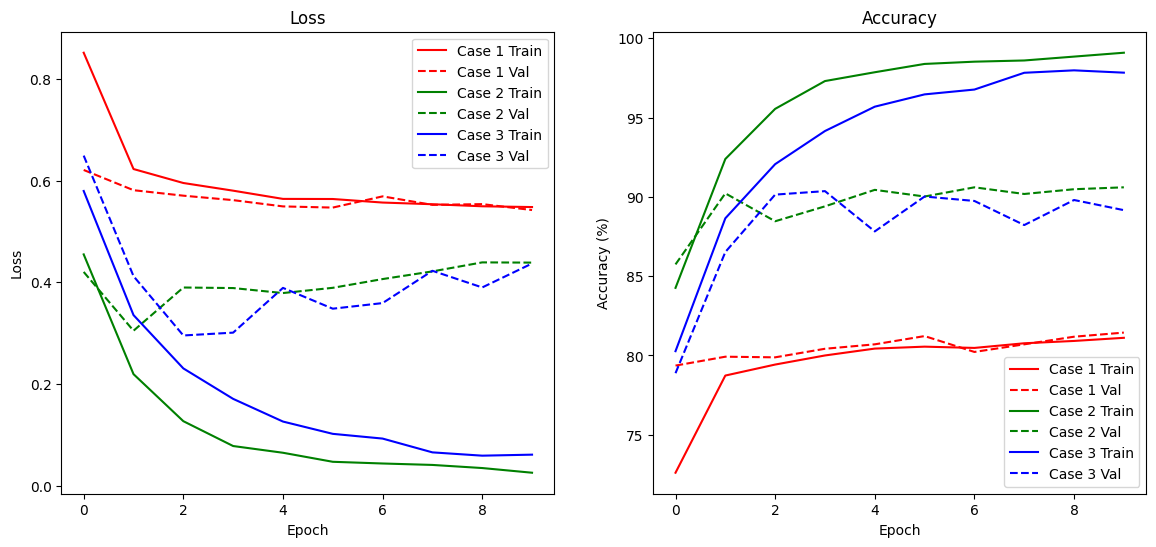

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create stratified splits for train and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
train_index, val_index = next(sss.split(np.zeros(len(targets)), targets))
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Function to create network instances
def create_network(case):
    net = models.resnet18(pretrained=True)
    if case == 1:
        # Case 1: Freeze all layers
        for param in net.parameters():
            param.requires_grad = False
    elif case == 2:
        # Case 2: Freeze all but the last three layers
        for name, child in net.named_children():
            if name not in ['layer4', 'avgpool', 'fc']:
                for param in child.parameters():
                    param.requires_grad = False
    # Case 3: Do not freeze any layers, i.e., all layers are trainable
    # No action needed, all parameters are trainable by default

    # Adjust the last fully connected layer for CIFAR-10
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 10)
    return net

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Step 4/5/6: Setup and train networks for each case
cases = {1: 'All frozen', 2: 'Last three unfrozen', 3: 'None frozen'}
results = {}

for case in cases:
    print(f"\nTraining case {case}: {cases[case]}")
    net = create_network(case).to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train and validate each case
    train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
    for epoch in range(10):
        # Training phase
        net.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(trainloader.sampler)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        # Validation phase
        net.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(valloader.sampler)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)

        print(f'Epoch {epoch+1} - Training Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Validation Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

    results[case] = (train_losses, train_accuracy, val_losses, val_accuracy)

# Step 7: Evaluate the network on the test data and plot results
print('Finished Training')
colors = ['r', 'g', 'b']
plt.figure(figsize=(14, 6))
for i, case in enumerate(results):
    train_losses, train_accuracy, val_losses, val_accuracy = results[case]
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, f'{colors[i]}-', label=f'Case {case} Train')
    plt.plot(val_losses, f'{colors[i]}--', label=f'Case {case} Val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, f'{colors[i]}-', label=f'Case {case} Train')
    plt.plot(val_accuracy, f'{colors[i]}--', label=f'Case {case} Val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

plt.show()